This notebook extracts geographic coordinates from a KML file, applies DBSCAN clustering, and visualizes the clusters using matplotlib and folium.


In [ ]:
import xml.etree.ElementTree as ET
!pip install folium
import folium
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import MarkerCluster
!pip install ortools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from geopy.distance import geodesic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.0 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


Step 1: Upload KML File


In [ ]:
# Step 1: Upload the .kml File
from google.colab import files

uploaded = files.upload()  # Use the file upload feature in Colab

Saving mavindini Ward.kml to mavindini Ward.kml


Step 2: Parse and Extract Coordinates


In [ ]:
# Step 2: Parse the .kml File and Extract Coordinates
kml_file_path = list(uploaded.keys())[0]

In [ ]:
tree = ET.parse(kml_file_path)
root = tree.getroot()

In [ ]:
namespace = {'kml': 'http://www.opengis.net/kml/2.2'}

In [ ]:
# Extract coordinates
coordinates = []
for coord in root.findall(".//kml:coordinates", namespace):
    coord_text = coord.text.strip()  # Get the coordinate text
    points = coord_text.split()  # Split by space to handle multiple points
    for point in points:
        lon, lat, _ = map(float, point.split(','))  # Extract longitude, latitude
        coordinates.append((lat, lon))  # Append as (latitude, longitude)

print(f"Extracted {len(coordinates)} locations:")
print(coordinates[:5])  # Display the first 5 locations

Extracted 464 locations:
[(-1.896894, 37.850253), (-1.791634, 37.770493), (-1.856807, 37.840179), (-1.897329, 37.845199), (-1.814132, 37.809584)]


In [ ]:
# Convert coordinates to a NumPy array for clustering
location_data = np.array(coordinates)

Step 3: Cluster Coordinates using DBSCAN

In [ ]:
# Perform DBSCAN clustering to group nearby locations
# Using haversine distance for geographical coordinates (requires radians)
dbscan = DBSCAN(eps=0.01, min_samples=5, metric='haversine')  # eps ~ 1 km
clusters = dbscan.fit_predict(np.radians(location_data))

In [ ]:
# Add cluster labels to the data
clustered_data = np.column_stack((location_data, clusters))

Step 4: Visualize Clusters (Matplotlib)


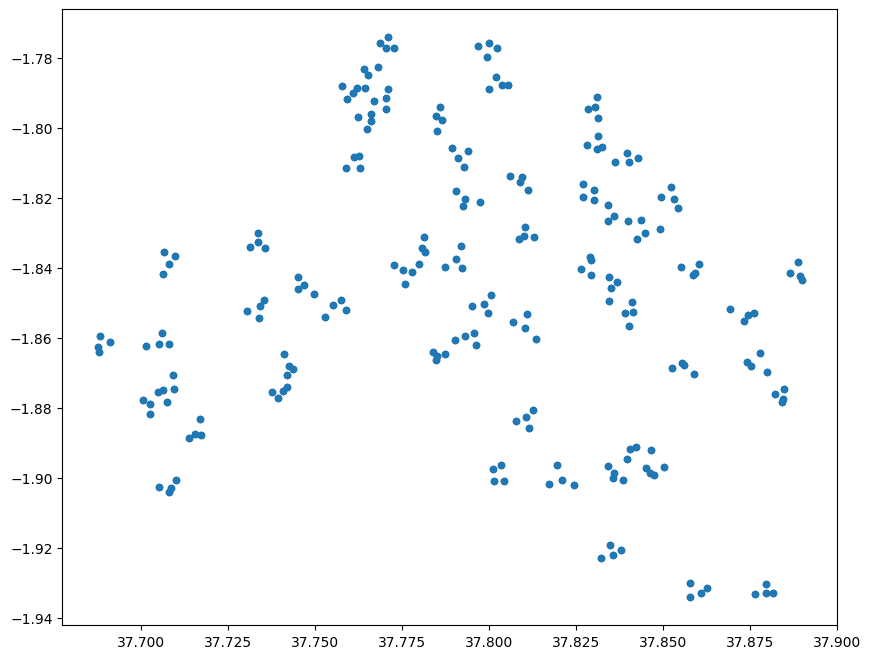

In [ ]:
# Step 4: Visualize Clusters
plt.figure(figsize=(10, 8))
unique_clusters = set(clusters)
for cluster in unique_clusters:
    if cluster == -1:  # Noise points
        color = 'gray'
        label = 'Noise'
    else:
        color = plt.cm.tab10(cluster % 10)
        label = f'Cluster {cluster}'

    cluster_points = clustered_data[clustered_data[:, 2] == cluster]
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=20, c=[color], label=label)

Step 5: Interactive Map (Folium)

In [ ]:
# Create a base map centered around the average latitude and longitude
map_center = [np.mean(location_data[:, 0]), np.mean(location_data[:, 1])]
m = folium.Map(location=map_center, zoom_start=12)

In [ ]:
# Create a MarkerCluster object to group the markers
marker_cluster = MarkerCluster().add_to(m)

In [ ]:
# Add markers for each location with a cluster label
for i, (lat, lon) in enumerate(coordinates):
    cluster_label = clusters[i]
    if cluster_label == -1:  # Noise points
        cluster_label = 'Noise'
    else:
        cluster_label = f'Cluster {cluster_label}'
    # Add a marker for the current location
    folium.Marker(
        location=[lat, lon],
        popup=cluster_label,  # Show the cluster label on click
        icon=folium.Icon(color='blue' if cluster_label == 'Noise' else 'green', icon='info-sign')
    ).add_to(marker_cluster)

# Display the map
m

In [ ]:
# Create a base map centered around the average latitude and longitude
map_center = [np.mean(location_data[:, 0]), np.mean(location_data[:, 1])]
m = folium.Map(location=map_center, zoom_start=12)

In [ ]:
# Create a MarkerCluster object to group the markers
marker_cluster = MarkerCluster(control=True).add_to(m)

In [ ]:
# Add markers for each location with a cluster label
for i, (lat, lon) in enumerate(coordinates):
    cluster_label = clusters[i]
    if cluster_label == -1:  # Noise points
        cluster_label = 'Noise'
    else:
        cluster_label = f'Cluster {cluster_label}'

    # Add a marker for the current location
    folium.Marker(
        location=[lat, lon],
        popup=cluster_label,  # Show the cluster label on click
        icon=folium.Icon(color='blue' if cluster_label == 'Noise' else 'green', icon='info-sign')
    ).add_to(marker_cluster)

# Display the map
m

In [ ]:
clustered_data = np.column_stack((location_data, clusters))
print(f"Number of clusters: {len(set(clusters)) - (1 if -1 in clusters else 0)}")

Number of clusters: 1


In [ ]:
def create_distance_matrix(locations):
    size = len(locations)
    distance_matrix = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            distance_matrix[i][j] = geodesic(locations[i], locations[j]).meters
    return distance_matrix

In [ ]:
def solve_tsp(distance_matrix):
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)

    # Create the routing model
    routing = pywrapcp.RoutingModel(manager)

    # Define the distance callback
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node][to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Set search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        route = []
        index = routing.Start(0)
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        return route
    else:
        return None


In [ ]:
map_center = np.mean(location_data, axis=0)
m = folium.Map(location=[map_center[0], map_center[1]], zoom_start=12)

In [ ]:
for cluster in set(clusters):
    if cluster == -1:
        continue  # Skip noise points

    # Get locations in the current cluster
    cluster_locations = location_data[clusters == cluster]

    # Create distance matrix
    distance_matrix = create_distance_matrix(cluster_locations)

    # Solve the TSP
    route_indices = solve_tsp(distance_matrix)
    if route_indices:
        # Extract the optimized route
        route = [cluster_locations[i] for i in route_indices]

        # Plot the route on the map
        for lat, lon in route:
            folium.Marker(location=[lat, lon]).add_to(m)
        folium.PolyLine(route, color="blue", weight=2.5, opacity=0.8).add_to(m)

# Display the map
m

In [ ]:
# Save the map to an HTML file
map_file = "optimized_routes_map.html"
m.save(map_file)

# Download the file
from google.colab import files
files.download(map_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>